# Submission Pertama : Customer Churn Prediction
Nama: Rahmat Fajri

email: rfajri912@gmail.com

Dataset yang digunakan pada project ini merupakan dataset [Telco Customer Churn](https://www.kaggle.com/blastchar/telco-customer-churn). 

Tujuan dari proyek ini adalah untuk memprediksi apakah customer akan berhenti menggunakan layanan (churn) atau tidak. Berdasarkan hasil analisis dan prediksi ini team yang memiliki kepentingan dapat membuat strategi yang tepat untuk memperkecil *churn rate*.

## Menyiapkan Library

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import joblib

In [160]:
sns.set(style='darkgrid')

## Mempersiapkan Dataset

In [161]:
df = pd.read_csv('data\Telco-Customer-Churn.csv')
df.head()


,customerID,gender,SeniorCitizen,Partner,StreamingTV,PhoneService,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,tenure,Churn
0,7590-VHVEG,Female,No,Yes,No,No,DSL,Yes,29.85,29.85,1,0
1,5575-GNVDE,Male,No,No,No,Yes,DSL,No,56.95,1889.50,34,0
2,3668-QPYBK,Male,No,No,No,Yes,DSL,Yes,53.85,108.15,2,1
3,7795-CFOCW,Male,No,No,No,No,DSL,No,42.30,1840.75,45,0
4,9237-HQITU,Female,No,No,No,Yes,Fiber optic,Yes,70.70,151.65,2,1


## Pemahaman Data (Data Understanding)

### Keterangan kolom pada dataset

Berdasarkan hasil tersebut dapat dilihat bahwa terdapat kesalahan tipe data untuk kolom `TotalCharges`, hal ini menunjukkan ada nilai yang diisi bukan dalam bentuk numerik. 

Selain itu, dapat dilihat bahwa dataset pada project ini didominasi oleh data kategorik.

In [162]:
# Memfilter data yang memiliki nilai ' '

df = df[df['TotalCharges'] != ' ']

In [163]:
# Mengubah  Dtype untuk kolom `TotalCharges` menjadi 'float'
df['TotalCharges'] = df.TotalCharges.astype(float)


### Memeriksa missing values

In [164]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
StreamingTV         0
PhoneService        0
InternetService     0
PaperlessBilling    0
MonthlyCharges      0
TotalCharges        0
tenure              0
Churn               0
dtype: int64

Setelah diperiksa ternyata tidak terdapat missing value pada dataset yang digunakan.

### Melihat rangkuman parameter statistik dari data numerik

In [165]:
df.describe()

,MonthlyCharges,TotalCharges,tenure,Churn
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,64.798208,2283.300441,32.421786,0.265785
std,30.085974,2266.771362,24.545260,0.441782
min,18.250000,18.800000,1.000000,0.000000
25%,35.587500,401.450000,9.000000,0.000000
50%,70.350000,1397.475000,29.000000,0.000000
75%,89.862500,3794.737500,55.000000,1.000000
max,118.750000,8684.800000,72.000000,1.000000


Berdasarkan hasil tersebut dapat disimpulkan bahwa kolom `MonthlyCharges`, & `TotalCharges` merupakan data numerik. Sedangkan kolom 'tenure' & `SeniorCitizen` merupakan kolom kategorik yang direpresentasikan dengan menggunakan angka.

### Memeriksa outlier dari data numerik

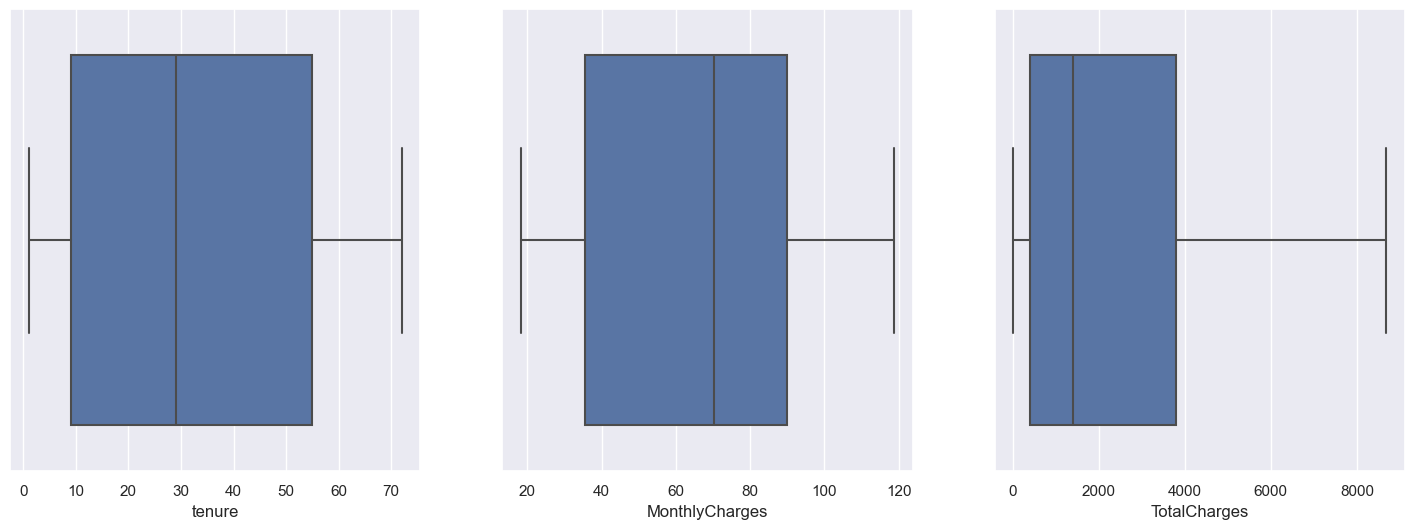

In [166]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.boxplot(x=df['tenure'], ax=ax[0])
sns.boxplot(x=df['MonthlyCharges'], ax=ax[1])
sns.boxplot(x=df['TotalCharges'], ax=ax[2])
plt.show()

Berdasarkan boxplot tersebut, tidak terdapat outlier pada data numerik.

### Memeriksa data `customerID` yang tidak valid

Data `customerID` harus memiliki nilai unique

In [167]:
df['customerID'].count()


7032

In [168]:
# Memeriksa apakah ada data yang sama pada kolom 'customerID'
df['customerID'].is_unique


True

### Memeriksa apakah terdapat Not Standard Values pada kolom kategorik

In [169]:
non_categorical_columns = ['customerID','tenure', 'MonthlyCharges', 'TotalCharges']
for column in df.columns:
    if column not in non_categorical_columns:
        print('\nUniq Values Count variabel '+column)
        print(df[column].value_counts())



Uniq Values Count variabel gender
Male      3549
Female    3483
Name: gender, dtype: int64

Uniq Values Count variabel SeniorCitizen
No     5890
Yes    1142
Name: SeniorCitizen, dtype: int64

Uniq Values Count variabel Partner
No     3639
Yes    3393
Name: Partner, dtype: int64

Uniq Values Count variabel StreamingTV
No                     2809
Yes                    2703
No internet service    1520
Name: StreamingTV, dtype: int64

Uniq Values Count variabel PhoneService
Yes    6352
No      680
Name: PhoneService, dtype: int64

Uniq Values Count variabel InternetService
Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64

Uniq Values Count variabel PaperlessBilling
Yes    4168
No     2864
Name: PaperlessBilling, dtype: int64

Uniq Values Count variabel Churn
0    5163
1    1869
Name: Churn, dtype: int64


Berdasarkan hasil tersebut ternyata tidak terdapat Not Standard Values pada kolom kategorik.

## Exploratory Data Analysis (EDA)

### Persentasi churn customer

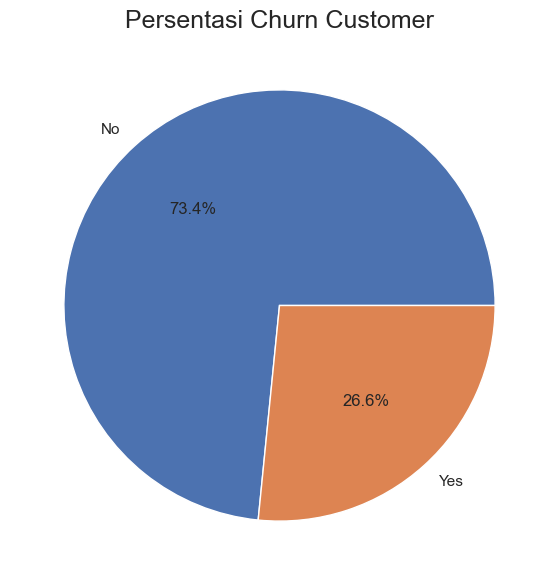

In [170]:
labels = ['No', 'Yes']
churn = df.Churn.value_counts()

plt.figure(figsize=(7, 7))
plt.pie(churn, labels=labels, autopct='%1.1f%%')
plt.title('Persentasi Churn Customer', loc='center', fontsize=18)
plt.savefig('images/persentasi_churn.png')
plt.show()


Berdasarkan plot tersebut dapat kita ketahui bahwa dari keseluruhan customer terdapat 26.4% customer yang melakukan churn.

### Plot distribusi untuk data kolom numerik

In [171]:
numerical_columns = ['MonthlyCharges', 'TotalCharges', 'tenure']
fig, ax = plt.subplots(1, 3, figsize=(14, 7))
df[df.Churn == 'No'][numerical_columns].hist(bins=20,
                                                    color='blue',
                                                    alpha=0.5,
                                                    ax=ax)
df[df.Churn == 'Yes'][numerical_columns].hist(bins=20,
                                                    color='orange',
                                                    alpha=0.5,
                                                    ax=ax)
plt.tight_layout()
plt.savefig('images/distribusi_kolom_numerik.png')
plt.show()


- Berdasarkan plot MonthlyCharges dapat kita ketahui bahwa semakin kecil biaya bulanan yang dikenakan, semakin kecil juga kecenderungan untuk melakukan churn
- Berdasarkan plot TotalCharges dapat dilihat bahwa tidak ada kecenderungan khusus apapun terhadap churn
- Berdasarkan plot tenure dapat kita ketahui bahwa ada kecenderungan semakin lama berlangganan, semakin kecil kecenderungan untuk melakukan churn

### Plot distribusi untuk data kolom kategorik

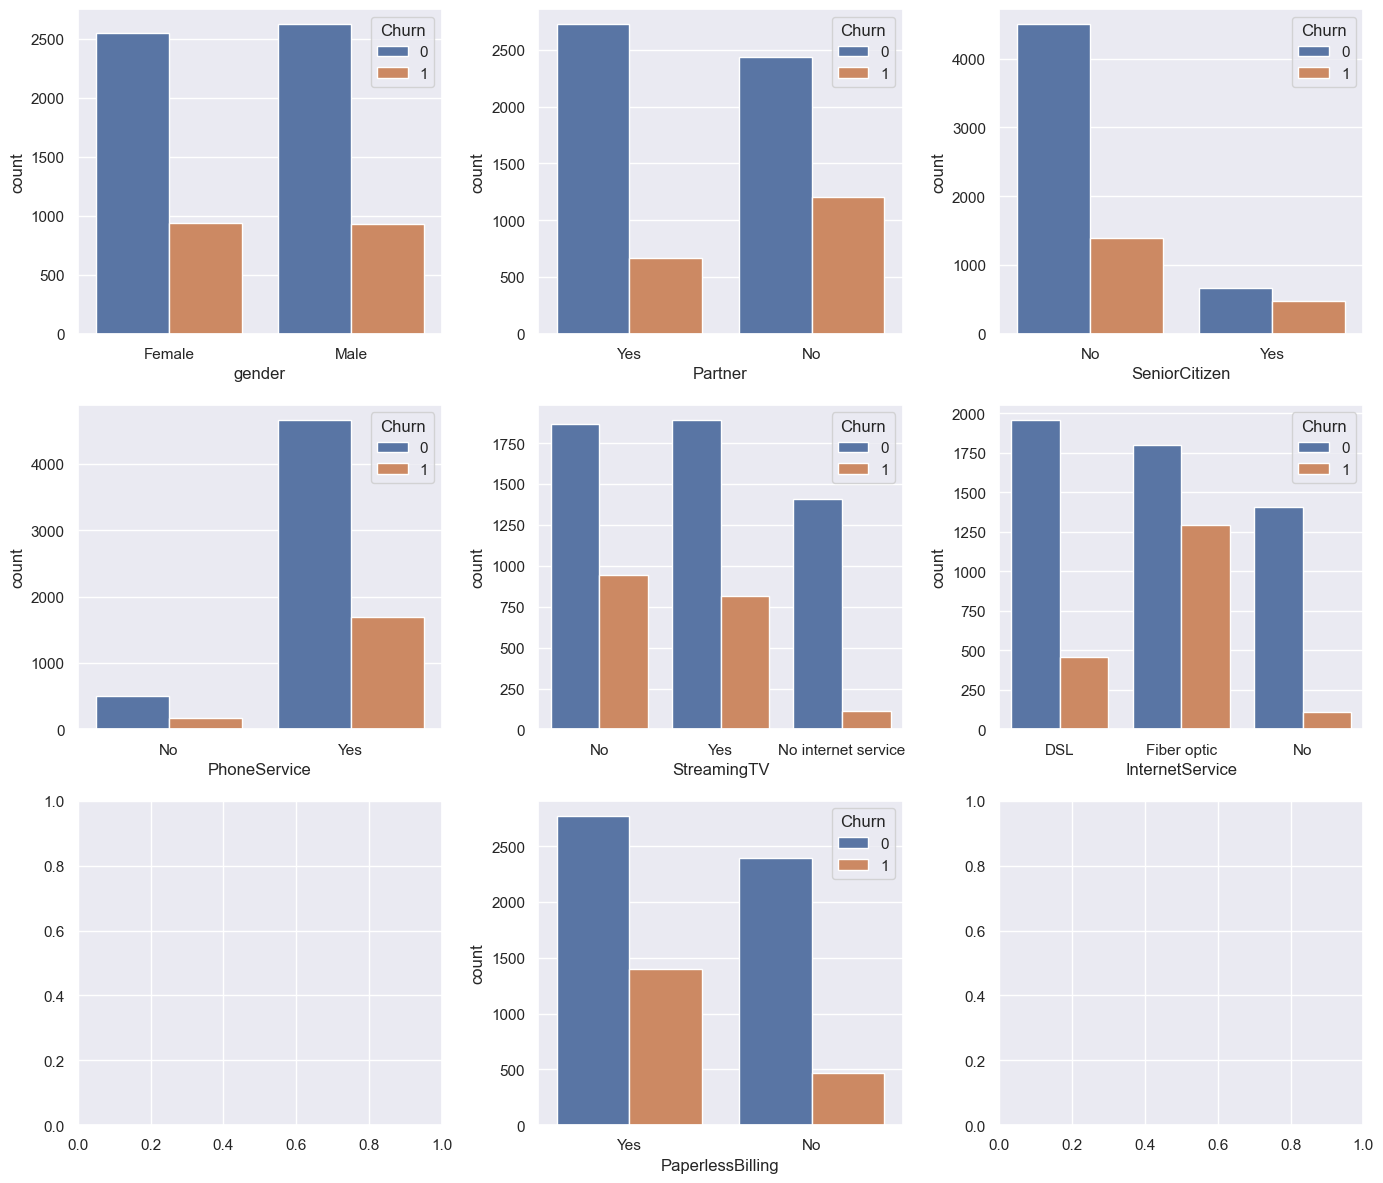

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(14, 12))
sns.countplot(data=df, x='gender', hue='Churn', ax=ax[0][0])
sns.countplot(data=df, x='Partner', hue='Churn', ax=ax[0][1])
sns.countplot(data=df, x='SeniorCitizen', hue='Churn', ax=ax[0][2])
sns.countplot(data=df, x='PhoneService', hue='Churn', ax=ax[1][0])
sns.countplot(data=df, x='StreamingTV', hue='Churn', ax=ax[1][1])
sns.countplot(data=df, x='InternetService', hue='Churn', ax=ax[1][2])
sns.countplot(data=df, x='PaperlessBilling', hue='Churn', ax=ax[2][1])
plt.tight_layout()
plt.savefig('images/distribusi_kolom_kategorik.png')
plt.show()


- Tidak ada perbedaan signifikan untuk melakukan churn jika dilihat faktor jenis kelamin (gender) dan layanan telfonnya (PhoneSevice)
- Ada kecenderungan melakukan churn untuk customer dengan kategori berikut:
  - Tidak memiliki partner (partner: No)
  - Orang-orang yang statusnya adalah senior citizen (SeniorCitizen: Yes)
  - Orang-orang yang mempunyai layanan streaming TV (StreamingTV: Yes)
  - Orang-orang yang mempunyai layanan Internet (internetService: Yes)
  - Orang-orang yang tagihannya paperless (PaperlessBilling: Yes)


## Data Preprocessing

### Menghilangkan kolom yang tidak dibutuhkan

In [ ]:
df.drop(['customerID'], axis=1, inplace=True)
df.head()

,gender,SeniorCitizen,Partner,StreamingTV,PhoneService,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,tenure,Churn
0,Female,No,Yes,No,No,DSL,Yes,29.85,29.85,1,0
1,Male,No,No,No,Yes,DSL,No,56.95,1889.50,34,0
2,Male,No,No,No,Yes,DSL,Yes,53.85,108.15,2,1
3,Male,No,No,No,No,DSL,No,42.30,1840.75,45,0
4,Female,No,No,No,Yes,Fiber optic,Yes,70.70,151.65,2,1


### Melakukan encoding untuk data kategorik

In [ ]:
LE = LabelEncoder()

for column in df.columns:
    if df[column].dtype == np.number:
        continue
    else:
        df[column] = LE.fit_transform(df[column])

df.describe()


C:\Users\Dicoding\AppData\Local\Temp\ipykernel_13564\3454667287.py:4: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df[column].dtype == np.number:


,gender,SeniorCitizen,Partner,StreamingTV,PhoneService,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,tenure,Churn
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.504693,0.162400,0.482509,0.984926,0.903299,0.872582,0.592719,64.798208,2283.300441,31.421786,0.265785
std,0.500014,0.368844,0.499729,0.885285,0.295571,0.737271,0.491363,30.085974,2266.771362,24.545260,0.441782
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,35.587500,401.450000,8.000000,0.000000
50%,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,70.350000,1397.475000,28.000000,0.000000
75%,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,89.862500,3794.737500,54.000000,1.000000
max,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,118.750000,8684.800000,71.000000,1.000000


### Train test split

In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=24)

In [ ]:
X_test.iloc[0]

gender                 1.00
SeniorCitizen          0.00
Partner                0.00
StreamingTV            2.00
PhoneService           1.00
InternetService        1.00
PaperlessBilling       1.00
MonthlyCharges        99.95
TotalCharges        1931.75
tenure                18.00
Name: 5732, dtype: float64

In [ ]:
print('Jumlah seluruh sampel pada dataset: ', len(X))
print('Jumlah seluruh sampel data training: ', len(X_train))
print('Jumlah seluruh sampel data testing: ', len(X_test))

Jumlah seluruh sampel pada dataset:  7032
Jumlah seluruh sampel data training:  6328
Jumlah seluruh sampel data testing:  704


### Standarisasi

In [ ]:

numerical_columns = ['MonthlyCharges', 'TotalCharges', 'tenure']
scaler = StandardScaler()
scaler.fit(X_train[numerical_columns])
X_train[numerical_columns] = scaler.transform(X_train.loc[:, numerical_columns])
X_train[numerical_columns].head()

,MonthlyCharges,TotalCharges,tenure
1458,0.184009,-0.885277,-1.162817
3090,0.661749,-0.617857,-0.877262
3070,1.355136,2.278942,1.570354
3754,0.290173,-0.906618,-1.203611
1271,-0.267190,0.360429,0.917656


In [ ]:
X_train[numerical_columns].describe()

,MonthlyCharges,TotalCharges,tenure
count,6.328000e+03,6.328000e+03,6.328000e+03
mean,-1.771304e-16,7.972272e-17,-8.814413e-17
std,1.000079e+00,1.000079e+00,1.000079e+00
min,-1.546140e+00,-1.000649e+00,-1.285198e+00
25%,-9.659678e-01,-8.294170e-01,-9.588494e-01
50%,1.840089e-01,-3.927124e-01,-1.429774e-01
75%,8.330221e-01,6.666802e-01,9.584497e-01
max,1.788087e+00,2.812527e+00,1.611147e+00


In [ ]:
X_test[numerical_columns] = scaler.transform(X_test.loc[:, numerical_columns])
X_test[numerical_columns].head()

,MonthlyCharges,TotalCharges,tenure
5732,1.164371,-0.158921,-0.550913
6965,0.237091,0.876194,1.203211
2970,-0.139461,-0.922282,-1.203611
2026,-1.320540,-0.953699,-1.122024
6847,0.804407,0.033212,-0.306152


## Modelling

### Model: Logistic Regression

In [ ]:
log_model = LogisticRegression()
log_model = log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)

In [ ]:
print('Evaluasi Model Logistic Regression:')

acc = round(accuracy_score(y_pred, y_test), 3)

print('Accuracy: ', acc)


Evaluasi Model Logistic Regression:
Accuracy:  0.793


In [ ]:
rdf_model = RandomForestClassifier()
rdf_model = rdf_model.fit(X_train, y_train)

y_pred = rdf_model.predict(X_test)

In [ ]:
print('Evaluasi Model Random Forest Classifier:')
acc = round(accuracy_score(y_pred, y_test), 3)

print('Accuracy: ', acc)


Evaluasi Model Random Forest Classifier:
Accuracy:  0.793


### Model: Gradient Boosting Classifier

In [ ]:
gbt_model = GradientBoostingClassifier()
gbt_model = gbt_model.fit(X_train, y_train)

y_pred = gbt_model.predict(X_test)

In [ ]:
print('Evaluasi Model Gradient Boosting Classifier:')
acc = round(accuracy_score(y_pred, y_test), 3)

print('Accuracy: ', acc)


Evaluasi Model Gradient Boosting Classifier:
Accuracy:  0.805


## Save model

In [ ]:
#export sklearn model into file
joblib.dump(log_model, 'model/log_model.joblib')

['model/log_model.joblib']

In [ ]:
joblib.dump(LE, "model/LabelEncoder.joblib")

['model/LabelEncoder.joblib']

In [ ]:
joblib.dump(scaler, "model/StandardScaler.joblib")

['model/StandardScaler.joblib']

In [ ]:
X_test.head()

,gender,SeniorCitizen,Partner,StreamingTV,PhoneService,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,tenure
5732,1,0,0,2,1,1,1,1.164371,-0.158921,-0.550913
6965,0,0,1,2,1,0,1,0.237091,0.876194,1.203211
2970,1,0,0,0,1,0,0,-0.139461,-0.922282,-1.203611
2026,0,0,1,0,0,0,0,-1.320540,-0.953699,-1.122024
6847,0,0,1,0,1,1,1,0.804407,0.033212,-0.306152


In [ ]:
list_ = {"data": [1,0, 0, 2, 1, 1, 1, -2.112979, -1.008991, -1.307672]}

In [ ]:
list_

{'data': [1, 0, 0, 2, 1, 1, 1, -2.112979, -1.008991, -1.307672]}

In [ ]:
list_["data"][:7] = [0, 0, 0, 0, 0, 0, 0]

In [ ]:
list_

{'data': [0, 0, 0, 0, 0, 0, 0, -2.112979, -1.008991, -1.307672]}

In [ ]:
list_["data"][-3:]

[-2.112979, -1.008991, -1.307672]